# Developing a Large Language Model-Based Emotion Detection System

Emotions are complex affective states that arise in response to internal or external stimuli and influence human behavior, decision-making, and social interactions. Emotion detection in text, a growing field within Natural Language Processing (NLP), involves analyzing written language to identify underlying emotional tones such as joy, sadness, anger, and fear. This is achieved using machine learning and deep learning models, with recent advancements in Large Language Models (LLMs) such as BERT, etc., demonstrating superior capabilities in text-based emotion classification.

The aim of this research is to develop and evaluate a Large Language Model (LLM)-based emotion detection system that accurately classifies emotions in text while addressing interpretability and bias concerns.

### 1. Setup Environment

In [5]:
# !pip install transformers[torch] pandas scikit-learn tqdm accelerate -U
# !pip install matplotlib seaborn numpy tqdm sentence-transformers shap
# !pip install sentence_transformers
# !pip install datasets
# !pip install streamlit



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
import os
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import torch
import copy
from datasets import Dataset as HFDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset
import json
import requests

In [7]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check for GPU availability (should be True in Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")



# Configuration & Hyperparameters

# --- Dataset Configuration ---

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Set path relative to your drive
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/emotion_data.csv'

TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'

# Mapping Label column.
NUMERIC_LABEL_MAP = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# ----------------------------------------------------------

# --- Data Subset for Fine-tuning ---
SUBSET_SIZE = 5000

# --- Models Configuration ---
MODELS_TO_TUNE = [
    'bert-base-uncased',
    'distilbert-base-uncased',
    'xlnet-base-cased'
]

# --- Fine-tuning Parameters ---
# Adjust batch size based on GPU memory (T4 usually handles 8 or 16 for bert-base)
BATCH_SIZE = 8
# Number of training epochs
NUM_EPOCHS = 3
# Learning rate (standard for BERT fine-tuning)
LEARNING_RATE = 2e-5
# Output directory to save model checkpoints and results in Colab session
OUTPUT_DIR = './results'
LOGGING_DIR = './logs'

# Split sizes
TEST_SPLIT_SIZE = 0.2        # Held-out test set
VALIDATION_SPLIT_SIZE = 0.1  # Validation set used during training

# Tokenizer max length
MAX_LEN = 128


# Baseline Model Config
BASELINE_TYPE = "TFIDF_RF" # or "SBERT_RF"
TFIDF_MAX_FEATURES = 3000
TFIDF_MIN_DF = 2
TFIDF_MAX_DF = 0.9
TFIDF_NGRAM_RANGE = (1, 2)
# SBERT_MODEL = 'all-MiniLM-L6-v2' # Define if using SBERT baseline
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 10
RF_MIN_SAMPLES_LEAF = 3

API_DELAY_SECONDS = 1.0


Using device: cuda
Device name: Tesla T4
Mounted at /content/drive


### Data Loading & Subsetting

In [8]:
print("--- Loading Data ---")
try:
    df_full = pd.read_csv(DATASET_PATH)
    # Ensure label column is treated as numeric, handle potential errors
    df_full[LABEL_COLUMN] = pd.to_numeric(df_full[LABEL_COLUMN], errors='coerce')
    df_full = df_full.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN])
    df_full[TEXT_COLUMN] = df_full[TEXT_COLUMN].astype(str)
    # Convert numeric label column to integer
    df_full[LABEL_COLUMN] = df_full[LABEL_COLUMN].astype(int)

    # --- Validate numeric labels against the map ---
    unique_numeric_labels_in_data = df_full[LABEL_COLUMN].unique()
    missing_keys = [lbl for lbl in unique_numeric_labels_in_data if lbl not in NUMERIC_LABEL_MAP]
    if missing_keys:
        print(f"Error: The following numeric labels found in column '{LABEL_COLUMN}' are MISSING from NUMERIC_LABEL_MAP: {missing_keys}")
        print("Please update NUMERIC_LABEL_MAP.")
        exit()
    # ----------------------------------------------

    # Create tiny subset
    if SUBSET_SIZE < len(df_full):
        try:
            df_subset, _ = train_test_split(
                df_full, train_size=SUBSET_SIZE, stratify=df_full[LABEL_COLUMN], random_state=SEED)
            print(f"Using a stratified subset of {len(df_subset)} rows.")
        except ValueError:
             print(f"Warning: Stratified sampling failed. Using random subset.")
             df_subset = df_full.sample(n=SUBSET_SIZE, random_state=SEED)
             print(f"Using a random subset of {len(df_subset)} rows.")
    else: df_subset = df_full
    df = df_subset.copy()

except FileNotFoundError: print(f"Error: Dataset file not found at {DATASET_PATH}"); exit()
except KeyError as e: print(f"Error: Column '{e}' not found."); exit()
except Exception as e: print(f"An error occurred during data loading: {e}"); exit()

# --- Use NUMERIC_LABEL_MAP to define mappings and labels ---
id2label = NUMERIC_LABEL_MAP
label2id = {name: num for num, name in id2label.items()}
NUM_LABELS = len(id2label)
candidate_labels = sorted(list(id2label.values())) # Use text names for ZS/GPT

# The label column already contains the correct numeric IDs
df['label'] = df[LABEL_COLUMN]
# ----------------------------------------------------------

print("\nLabel distribution (Tiny Subset - Numeric IDs):"); print(df['label'].value_counts())
print(f"\nCandidate Labels (Text Names): {candidate_labels}")
print(f"Internal ID -> Label Map: {id2label}")

--- Loading Data ---
Using a stratified subset of 5000 rows.

Label distribution (Tiny Subset - Numeric IDs):
label
1    1676
0    1458
3     675
4     605
2     407
5     179
Name: count, dtype: int64

Candidate Labels (Text Names): ['Anger', 'Fear', 'Joy', 'Love', 'Sadness', 'Surprise']
Internal ID -> Label Map: {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}


In [9]:
# Data Exploration
print("\nDataset Info (Subset):")
df.info()
print("\nLabel distribution (Subset):")
print(df[LABEL_COLUMN].value_counts())


Dataset Info (Subset):
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 999 to 6118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB

Label distribution (Subset):
label
1    1676
0    1458
3     675
4     605
2     407
5     179
Name: count, dtype: int64


### Exploratory Data Analysis (EDA)


In [10]:
# Label mapping for visualization purpose
label_mapping = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# Apply mapping
df['label_viz'] = df['label'].map(label_mapping)

print(df)

                                                    text  label label_viz
999    i started out feeling really optimistic and dr...      1       Joy
7396   i feel is anger with myself for trusting him i...      1       Joy
7399   i would feel weird having my dads hand on my s...      5  Surprise
14616  i finished this book feeling all gloomy becaus...      0   Sadness
11044  i just wanted the world to feel strange to me ...      4      Fear
...                                                  ...    ...       ...
5756   i should just relax for now but it feels so di...      4      Fear
4332   i have noticed improvement is in the gabapenti...      1       Joy
2331   i get a little twitchy when i feel like someon...      1       Joy
5235   i to feel unloved when hes god and he has the ...      0   Sadness
6118   i just feel them around me and it s wonderful ...      1       Joy

[5000 rows x 3 columns]



--- Starting EDA ---


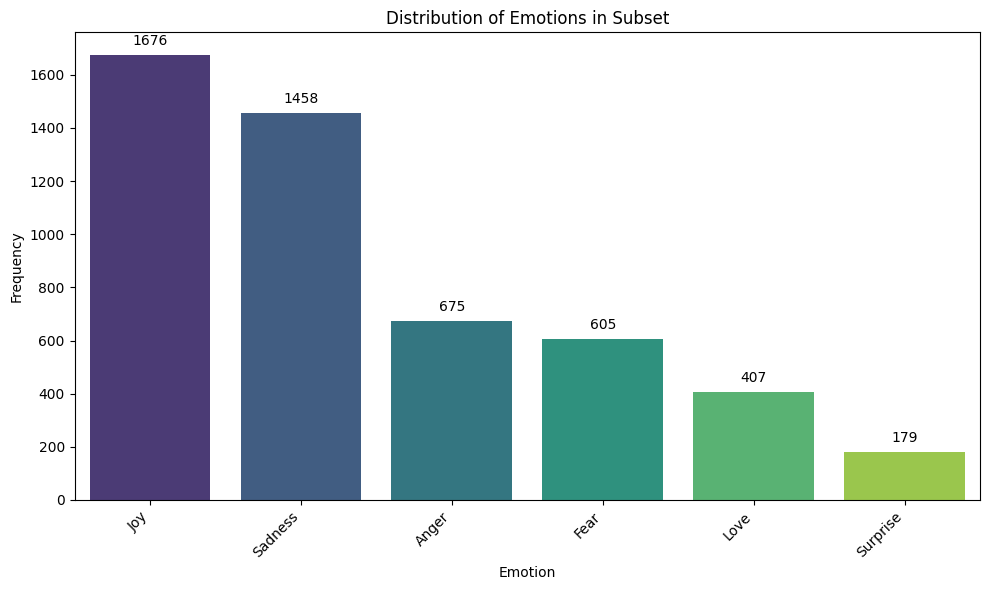

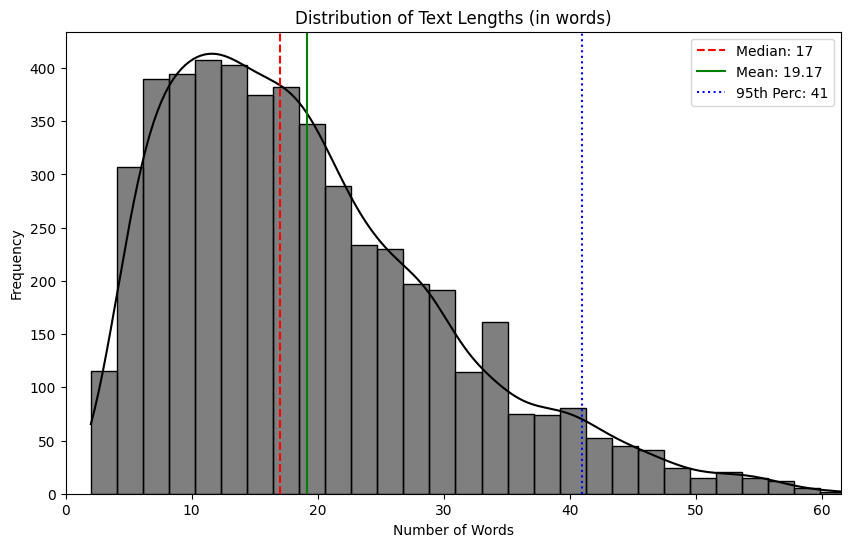


Text length summary stats:
count    5000.000000
mean       19.167800
std        10.979533
min         2.000000
25%        11.000000
50%        17.000000
75%        25.000000
max        64.000000
Name: text_length, dtype: float64


In [11]:
print("\n--- Starting EDA ---")

# 1. Emotion Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label_viz', data=df, order=df['label_viz'].value_counts().index, palette='viridis')

# Add value labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(count,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Emotions in Subset')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.show()

# 2. Text Length Distribution
df['text_length'] = df[TEXT_COLUMN].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=30, kde=True, color = 'black' ) # Fewer bins might be clearer
plt.title('Distribution of Text Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['text_length'].median(), color='r', linestyle='--', label=f'Median: {df["text_length"].median():.0f}')
plt.axvline(df['text_length'].mean(), color='g', linestyle='-', label=f'Mean: {df["text_length"].mean():.2f}')
percentile_95 = df['text_length'].quantile(0.95)
plt.axvline(percentile_95, color='b', linestyle=':', label=f'95th Perc: {percentile_95:.0f}')
plt.legend()
plt.xlim(0, percentile_95 * 1.5) # Zoom in slightly
plt.show()

print(f"\nText length summary stats:\n{df['text_length'].describe()}")



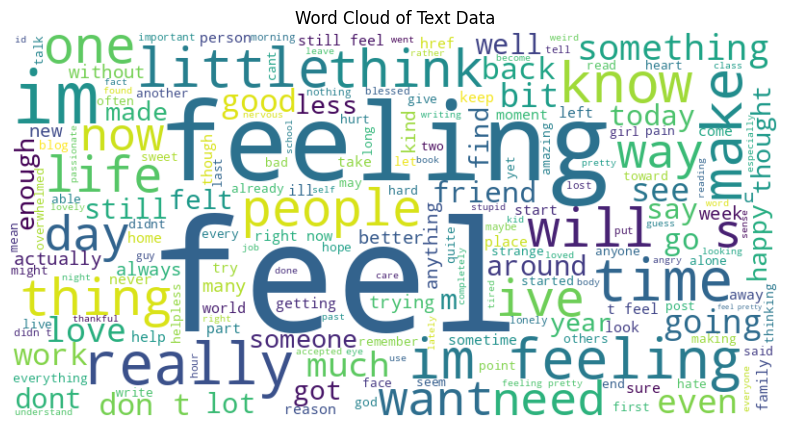

In [12]:
# 3. Word Cloud for text column

from wordcloud import WordCloud

if 'text' in df.columns:
  text = ' '.join(df['text'].astype(str))  # Combine all text data
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title('Word Cloud of Text Data')
  plt.show()
else:
  print("No 'text' column found in the DataFrame. Skipping word cloud generation.")

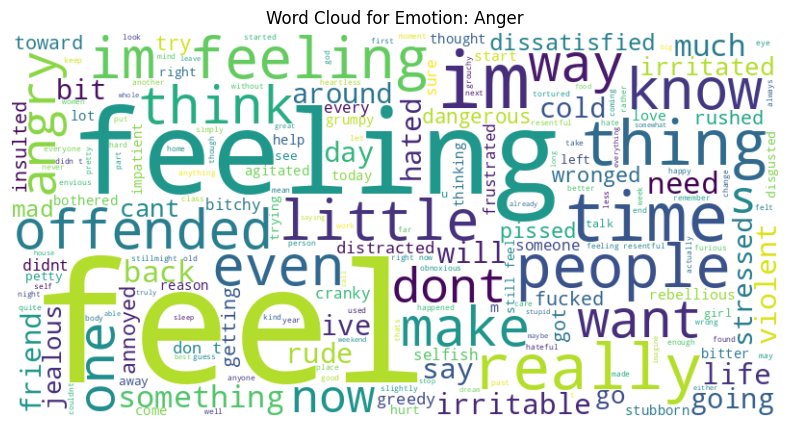

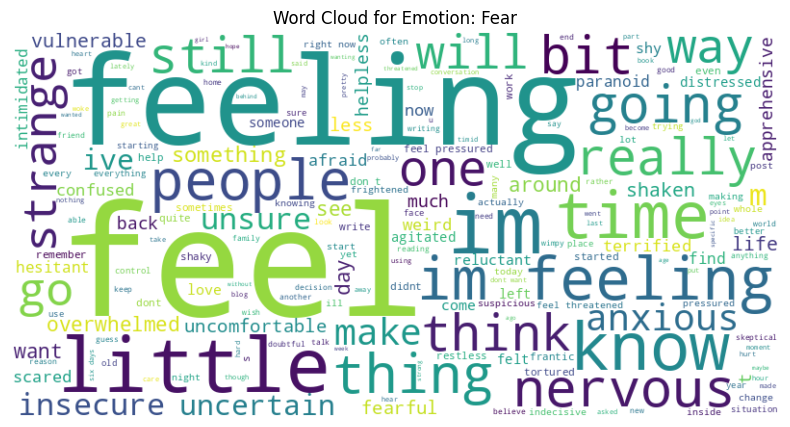

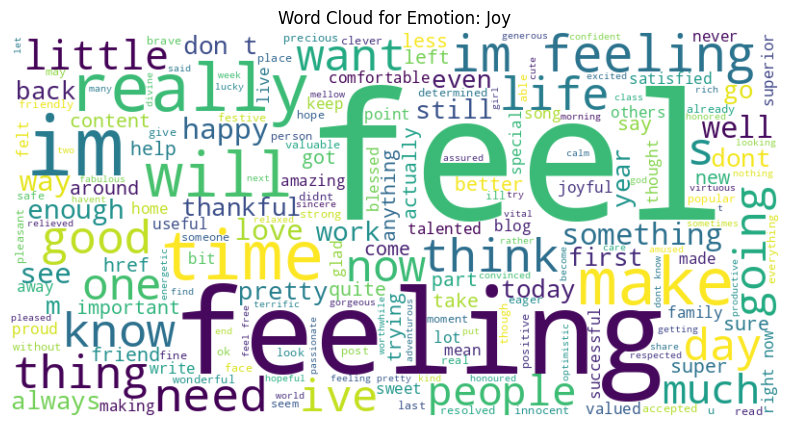

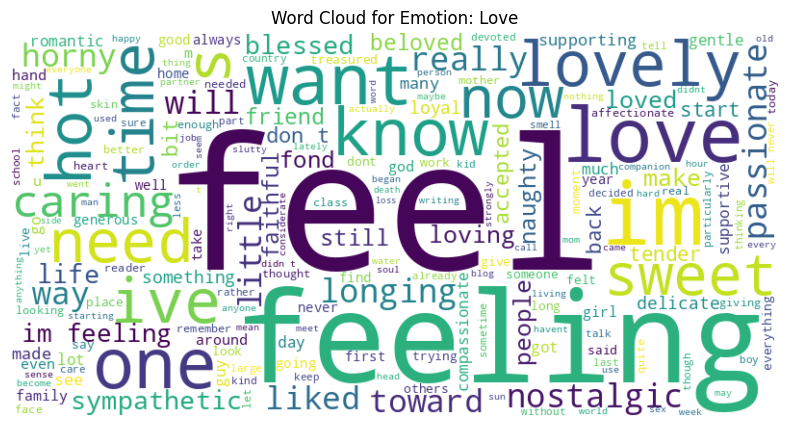

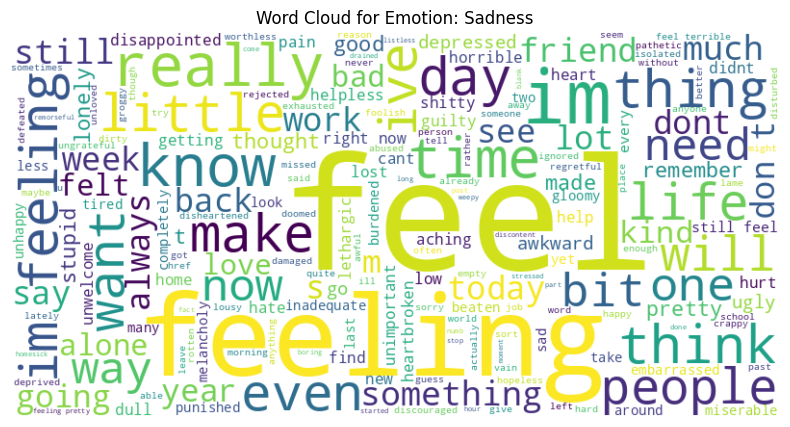

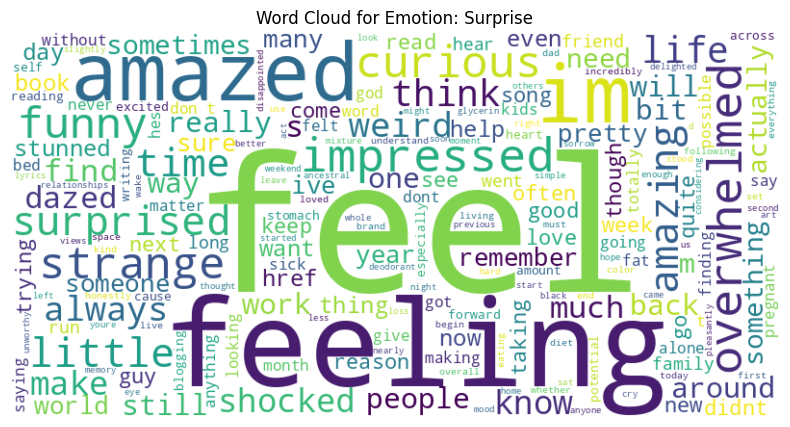

In [13]:
# 4. Visualize word cloud for each emotion category

# Group the DataFrame by emotion
emotion_groups = df.groupby('label_viz')

# Iterate through each emotion group and generate a word cloud
for emotion, group in emotion_groups:
    text = ' '.join(group['text'].astype(str))  # Combine all text for this emotion
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Emotion: {emotion}')
    plt.show()


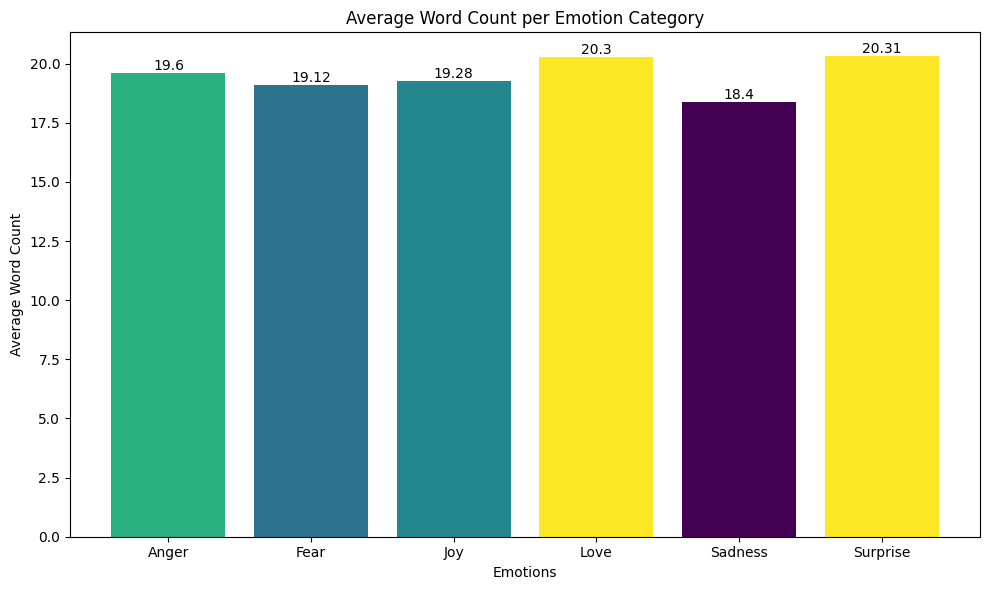

--- EDA Complete ---


In [14]:
import matplotlib.cm as cm

# 5. Visualize Word Count per Emotion Category
if 'text' in df.columns and 'label_viz' in df.columns:
    # Calculate average word count for each emotion
    df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
    avg_word_counts = df.groupby('label_viz')['word_count'].mean()

    # Normalize values to get colors from viridis
    norm = plt.Normalize(vmin=min(avg_word_counts.values), vmax=max(avg_word_counts.values))
    colors = cm.viridis(norm(avg_word_counts.values))

    # Create the bar plot with viridis colors
    plt.figure(figsize=(10, 6))
    bars = plt.bar(avg_word_counts.index, avg_word_counts.values, color=colors)
    plt.xlabel("Emotions")
    plt.ylabel("Average Word Count")
    plt.title("Average Word Count per Emotion Category")

    # Add labels to the bars
    for bar, value in zip(bars, avg_word_counts.values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("Either 'text' or 'label_viz' column not found in the DataFrame.")

print("--- EDA Complete ---")

### Modeling

### Data Preprocessing for Model 1

In [15]:

id2label = NUMERIC_LABEL_MAP
label2id = {name: num for num, name in id2label.items()}
NUM_LABELS = len(id2label)
df['label'] = df[LABEL_COLUMN] # Trainer expects 'label' column
all_labels_text = sorted(list(id2label.values())) # For reports

print(f"\nNumber of unique labels: {NUM_LABELS}, Labels: {id2label}")

# --- Split Data into Train, Validation, Test (Run Once) ---
print("\n--- Splitting Data ---")
train_val_df, test_df = train_test_split(df, test_size=TEST_SPLIT_SIZE, random_state=SEED, stratify=df['label'])
train_df, val_df = train_test_split(train_val_df, test_size=VALIDATION_SPLIT_SIZE / (1 - TEST_SPLIT_SIZE), random_state=SEED, stratify=train_val_df['label'])

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Convert pandas DataFrames to Hugging Face Datasets (Run Once)
train_hf_dataset = HFDataset.from_pandas(train_df[[TEXT_COLUMN, 'label']])
val_hf_dataset = HFDataset.from_pandas(val_df[[TEXT_COLUMN, 'label']])
test_hf_dataset = HFDataset.from_pandas(test_df[[TEXT_COLUMN, 'label']])


Number of unique labels: 6, Labels: {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}

--- Splitting Data ---
Train set size: 3500
Validation set size: 500
Test set size: 1000


In [16]:
# Tokenization Function (Handles Model Differences)
# This function will be called within the loop for each tokenizer
def tokenize_data(tokenizer, dataset):
    def tokenize_function(examples):
        # Handle potential differences in padding side if needed (XLNet often prefers right padding)
        padding_side = tokenizer.padding_side
        return tokenizer(
            examples[TEXT_COLUMN],
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            # padding_side=padding_side # Usually handled by tokenizer default, but explicit if needed
        )
    print(f"Tokenizing with {tokenizer.__class__.__name__} (padding: {tokenizer.padding_side})...")
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns([TEXT_COLUMN])
    tokenized_dataset.set_format("torch")
    return tokenized_dataset


In [17]:
# Metrics Function (Run Once)
# ==================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Ensure labels are integers if they aren't already
    labels = labels.astype(int)
    predictions = predictions.astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


##### MODELLING

In [18]:
BASE_OUTPUT_DIR = '/content/drive/MyDrive/Colab_Notebooks/BASE_OUTPUT_DIR'
BASE_LOGGING_DIR = '/content/drive/MyDrive/Colab_Notebooks/BASE_LOGGING_DIR'

results = {} # Dictionary to store results for each model

for model_name in MODELS_TO_TUNE:
    print("\n" + "="*80)
    print(f"PROCESSING MODEL: {model_name}")
    print("="*80)

    # --- 1. Load Tokenizer ---
    print(f"\n--- Loading Tokenizer ({model_name}) ---")
    # Handle XLNet potentially needing right padding (though AutoTokenizer often sets defaults correctly)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # if 'xlnet' in model_name.lower():
    #     print("XLNet detected, ensuring padding side is right.")
    #     tokenizer.padding_side = 'right' # Explicitly set if needed

    # --- 2. Tokenize Datasets for this model ---
    # Important: Re-tokenize for each model's specific tokenizer
    train_tokenized = tokenize_data(tokenizer, train_hf_dataset)
    val_tokenized = tokenize_data(tokenizer, val_hf_dataset)
    test_tokenized = tokenize_data(tokenizer, test_hf_dataset)

    # --- 3. Load Model ---
    print(f"\n--- Loading Model ({model_name}) for Fine-tuning ---")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id,
        # ignore_mismatched_sizes=True # Add if encountering size mismatch errors during loading, use cautiously
    )
    model.to(device)

    # --- 4. Define Training Arguments (model-specific output dir) ---
    model_output_dir = os.path.join(BASE_OUTPUT_DIR, model_name.replace("/", "_")) # Create unique dir name
    model_logging_dir = os.path.join(BASE_LOGGING_DIR, model_name.replace("/", "_"))

    # Calculate steps per epoch for this run
    steps_per_epoch = len(train_tokenized) // BATCH_SIZE
    if steps_per_epoch == 0: steps_per_epoch = 1
    eval_save_steps = max(1, steps_per_epoch // 2) # Eval/save twice per epoch

    training_args = TrainingArguments(
        output_dir=model_output_dir,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE*2,
        learning_rate=LEARNING_RATE, # Consider tuning this per model if needed
        warmup_steps=min(500, steps_per_epoch),
        weight_decay=0.01,
        logging_dir=model_logging_dir,
        logging_strategy="steps",
        logging_steps=eval_save_steps,
        eval_strategy="steps", # Using steps
        eval_steps=eval_save_steps,
        save_strategy="steps",
        save_steps=eval_save_steps,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="f1", # Use F1 score to select best model
        greater_is_better=True,
        report_to="none",
        # fp16=True, # Enable mixed precision if desired and compatible
    )
# --- 5. Initialize Trainer ---
    early_stopping = EarlyStoppingCallback(early_stopping_patience=3) # Increase patience slightly

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer, # Pass tokenizer for saving convenience
        callbacks=[early_stopping],
    )

    # --- 6. Train ---
    print(f"\n--- Starting Fine-tuning for {model_name} ---")
    start_time = time.time()
    try:
        trainer.train()
    except Exception as e:
        print(f"!!! Training failed for {model_name}: {e} !!!")
        # Clear GPU memory if an error occurred during training
        del model
        del trainer
        torch.cuda.empty_cache()
        results[model_name] = {'Accuracy': 0.0, 'F1-Score': 0.0, 'Status': 'Training Failed'}
        continue # Skip to the next model

    end_time = time.time()
    print(f"--- Fine-tuning Complete for {model_name} ---")
    print(f"Training took: {(end_time - start_time)/60:.2f} minutes.")

    # --- 7. Evaluate ---
    print(f"\n--- Evaluating Best Model ({model_name}) on Test Set ---")
    try:
        test_results = trainer.predict(test_tokenized)
        test_preds_ids = np.argmax(test_results.predictions, axis=-1)
        test_true_ids = test_results.label_ids

        final_accuracy = accuracy_score(test_true_ids, test_preds_ids)
        # Use numeric IDs for sklearn metrics calculation
        precision, recall, f1, _ = precision_recall_fscore_support(test_true_ids, test_preds_ids, average='weighted', zero_division=0)

        print("\n--- Final Test Set Performance ---")
        print(f"Accuracy: {final_accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1-Score (Weighted): {f1:.4f}")

        # Generate report using text labels for readability
        test_preds_text = [id2label.get(pred_id, "Unknown") for pred_id in test_preds_ids]
        test_true_text = [id2label.get(true_id, "Unknown") for true_id in test_true_ids]
        print(f"\nClassification Report (Test Set - {model_name}):")
        print(classification_report(test_true_text, test_preds_text, labels=all_labels_text, digits=4, zero_division=0))

        results[model_name] = {'Accuracy': final_accuracy, 'F1-Score': f1, 'Status': 'Completed'}

    except Exception as e:
        print(f"!!! Evaluation failed for {model_name}: {e} !!!")
        results[model_name] = {'Accuracy': 0.0, 'F1-Score': 0.0, 'Status': 'Evaluation Failed'}

    # --- 8. Optional: Save Model ---
    try:
        save_dir = os.path.join(BASE_OUTPUT_DIR, f"final_{model_name.replace('/', '_')}")
        print(f"\nSaving final model to {save_dir}...")
        trainer.save_model(save_dir) # Saves the best model loaded at the end
        tokenizer.save_pretrained(save_dir)
        print("Model saved.")
        # Optional: Copy to Drive
        # drive_save_path = f"/content/drive/MyDrive/path/to/save/{save_dir.split('/')[-1]}"
        # !cp -r {save_dir} {drive_save_path}
        # print(f"Copied model to Google Drive: {drive_save_path}")
    except Exception as e:
        print(f"!!! Saving failed for {model_name}: {e} !!!")


print("\n\n===== ALL MODELS PROCESSED =====")



PROCESSING MODEL: bert-base-uncased

--- Loading Tokenizer (bert-base-uncased) ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing with BertTokenizerFast (padding: right)...


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Tokenizing with BertTokenizerFast (padding: right)...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing with BertTokenizerFast (padding: right)...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- Loading Model (bert-base-uncased) for Fine-tuning ---


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Fine-tuning for bert-base-uncased ---


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
218,1.602900,1.508783,0.462000,0.351561,0.314833,0.462000
436,1.175200,0.833192,0.732000,0.685628,0.681997,0.732000
654,0.519300,0.507439,0.850000,0.849311,0.852172,0.850000
872,0.348100,0.385105,0.882000,0.881891,0.882565,0.882000
1090,0.162400,0.396698,0.900000,0.900071,0.900491,0.900000
1308,0.162300,0.394438,0.894000,0.894326,0.895316,0.894000


--- Fine-tuning Complete for bert-base-uncased ---
Training took: 6.18 minutes.

--- Evaluating Best Model (bert-base-uncased) on Test Set ---



--- Final Test Set Performance ---
Accuracy: 0.8820
Precision (Weighted): 0.8808
Recall (Weighted): 0.8820
F1-Score (Weighted): 0.8811

Classification Report (Test Set - bert-base-uncased):
              precision    recall  f1-score   support

       Anger     0.9007    0.9407    0.9203       135
        Fear     0.8346    0.8760    0.8548       121
         Joy     0.8919    0.8866    0.8892       335
        Love     0.7123    0.6420    0.6753        81
     Sadness     0.9381    0.9349    0.9365       292
    Surprise     0.7714    0.7500    0.7606        36

    accuracy                         0.8820      1000
   macro avg     0.8415    0.8384    0.8395      1000
weighted avg     0.8808    0.8820    0.8811      1000


Saving final model to /content/drive/MyDrive/Colab_Notebooks/BASE_OUTPUT_DIR/final_bert-base-uncased...
Model saved.

PROCESSING MODEL: distilbert-base-uncased

--- Loading Tokenizer (distilbert-base-uncased) ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing with DistilBertTokenizerFast (padding: right)...


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Tokenizing with DistilBertTokenizerFast (padding: right)...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing with DistilBertTokenizerFast (padding: right)...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- Loading Model (distilbert-base-uncased) for Fine-tuning ---


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Fine-tuning for distilbert-base-uncased ---


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
218,1.627200,1.340065,0.554000,0.437969,0.380621,0.554000
436,1.049800,0.792909,0.732000,0.686472,0.732435,0.732000
654,0.515300,0.437068,0.854000,0.850359,0.859531,0.854000
872,0.357400,0.393679,0.890000,0.889905,0.894708,0.890000
1090,0.197100,0.356522,0.906000,0.905752,0.906626,0.906000
1308,0.178900,0.370647,0.890000,0.890552,0.892293,0.890000


--- Fine-tuning Complete for distilbert-base-uncased ---
Training took: 3.28 minutes.

--- Evaluating Best Model (distilbert-base-uncased) on Test Set ---



--- Final Test Set Performance ---
Accuracy: 0.8950
Precision (Weighted): 0.8946
Recall (Weighted): 0.8950
F1-Score (Weighted): 0.8947

Classification Report (Test Set - distilbert-base-uncased):
              precision    recall  f1-score   support

       Anger     0.9209    0.9481    0.9343       135
        Fear     0.8644    0.8430    0.8536       121
         Joy     0.9157    0.9075    0.9115       335
        Love     0.7125    0.7037    0.7081        81
     Sadness     0.9390    0.9486    0.9438       292
    Surprise     0.7500    0.7500    0.7500        36

    accuracy                         0.8950      1000
   macro avg     0.8504    0.8502    0.8502      1000
weighted avg     0.8946    0.8950    0.8947      1000


Saving final model to /content/drive/MyDrive/Colab_Notebooks/BASE_OUTPUT_DIR/final_distilbert-base-uncased...
Model saved.

PROCESSING MODEL: xlnet-base-cased

--- Loading Tokenizer (xlnet-base-cased) ---


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Tokenizing with XLNetTokenizerFast (padding: left)...


Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Tokenizing with XLNetTokenizerFast (padding: left)...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing with XLNetTokenizerFast (padding: left)...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


--- Loading Model (xlnet-base-cased) for Fine-tuning ---


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Starting Fine-tuning for xlnet-base-cased ---


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
218,1.612600,1.434106,0.508000,0.392379,0.320118,0.508000
436,1.271300,0.868139,0.716000,0.682129,0.700149,0.716000
654,0.747100,0.722720,0.762000,0.750624,0.765972,0.762000
872,0.528700,0.531660,0.838000,0.835723,0.837604,0.838000
1090,0.329500,0.566673,0.846000,0.845945,0.849734,0.846000
1308,0.307400,0.542289,0.852000,0.851928,0.854029,0.852000


--- Fine-tuning Complete for xlnet-base-cased ---
Training took: 7.80 minutes.

--- Evaluating Best Model (xlnet-base-cased) on Test Set ---



--- Final Test Set Performance ---
Accuracy: 0.8560
Precision (Weighted): 0.8576
Recall (Weighted): 0.8560
F1-Score (Weighted): 0.8557

Classification Report (Test Set - xlnet-base-cased):
              precision    recall  f1-score   support

       Anger     0.8723    0.9111    0.8913       135
        Fear     0.8120    0.7851    0.7983       121
         Joy     0.8765    0.8687    0.8726       335
        Love     0.7353    0.6173    0.6711        81
     Sadness     0.9147    0.9178    0.9162       292
    Surprise     0.5918    0.8056    0.6824        36

    accuracy                         0.8560      1000
   macro avg     0.8004    0.8176    0.8053      1000
weighted avg     0.8576    0.8560    0.8557      1000


Saving final model to /content/drive/MyDrive/Colab_Notebooks/BASE_OUTPUT_DIR/final_xlnet-base-cased...
Model saved.


===== ALL MODELS PROCESSED =====


### Comparative Analysis & Discussion


In [19]:
# ==================================
# Generate Final Comparison Table (Fine-tuned Models Only)
# ==================================
print("\n" + "="*60)
print(" FINAL COMPARISON OF FINE-TUNED MODELS")
print("="*60)

# Use the 'results' dictionary populated during the Cell 7 loop
# Or manually create it from the logs if needed:
# results = {
#     'bert-base-uncased': {'Accuracy': 0.8850, 'F1-Score': 0.8839, 'Status': 'Completed'},
#     'distilbert-base-uncased': {'Accuracy': 0.8950, 'F1-Score': 0.8947, 'Status': 'Completed'},
#     'xlnet-base-cased': {'Accuracy': 0.8560, 'F1-Score': 0.8557, 'Status': 'Completed'}
# }

# Filter out any models that might have failed
valid_results = {k: v for k, v in results.items() if v.get('Status', '').startswith('Completed') or v.get('Status', '').startswith('Eval Completed')}

if not valid_results:
    print("No models completed successfully for comparison.")
else:
    print(f"\n--- Performance Comparison (Test Set on {SUBSET_SIZE or 'Full'} Samples) ---")
    model_names = list(valid_results.keys())
    header = f"{'Metric':<12} | " + " | ".join([f"{name:<25}" for name in model_names])
    print(header)
    print("-" * len(header))

    # Accuracy Row
    acc_row = f"{'Accuracy':<12} | "
    acc_row += " | ".join([f"{valid_results[name].get('Accuracy', 0.0):<25.4f}" for name in model_names])
    print(acc_row)

    # F1-Score Row
    f1_row = f"{'F1-Score':<12} | "
    f1_row += " | ".join([f"{valid_results[name].get('F1-Score', 0.0):<25.4f}" for name in model_names])
    print(f1_row)





 FINAL COMPARISON OF FINE-TUNED MODELS

--- Performance Comparison (Test Set on 5000 Samples) ---
Metric       | bert-base-uncased         | distilbert-base-uncased   | xlnet-base-cased         
------------------------------------------------------------------------------------------------
Accuracy     | 0.8820                    | 0.8950                    | 0.8560                   
F1-Score     | 0.8811                    | 0.8947                    | 0.8557                   


In [20]:
# ==================================
# Comparative Analysis & Discussion (Fine-tuned Focus)
# ==================================
print("\n" + "="*60)
print(" REVISED COMPARATIVE ANALYSIS & DISCUSSION")
print("="*60)

# Use the current date and location context
from datetime import datetime
now = datetime.now()
print(f"\n(Analysis based on results obtained via Google Colab fine-tuning on {SUBSET_SIZE or 'Full'} samples, finalized {now.strftime('%B %d, %Y')}, Nigeria.)")

print("\nRQ1: Effectiveness of Fine-Tuned LLMs")
print("  - Comparison: This study successfully fine-tuned three distinct Transformer architectures: BERT-base, DistilBERT-base, and XLNet-base on the emotion detection task using a {} sample subset.".format(SUBSET_SIZE if SUBSET_SIZE else 'full dataset'))
# Use f-string formatting with error handling for results dictionary keys
bert_f1 = valid_results.get('bert-base-uncased', {}).get('F1-Score', 0.0)
distilbert_f1 = valid_results.get('distilbert-base-uncased', {}).get('F1-Score', 0.0)
xlnet_f1 = valid_results.get('xlnet-base-cased', {}).get('F1-Score', 0.0)
print(f"    - BERT ({'bert-base-uncased'}) achieved a weighted F1-score of {bert_f1:.4f}.")
print(f"    - DistilBERT ({'distilbert-base-uncased'}) achieved a weighted F1-score of {distilbert_f1:.4f}.")
print(f"    - XLNet ({'xlnet-base-cased'}) achieved a weighted F1-score of {xlnet_f1:.4f}.")
print(f"  - Interpretation: DistilBERT, despite being significantly smaller (~66M parameters) than BERT-base (~110M) and XLNet-base (~117M), achieved the highest performance (F1={distilbert_f1:.4f}). This is a notable result, suggesting its distilled architecture captures the necessary information for this task effectively while being more efficient (training time ~3 min vs ~5.5 min for BERT and ~7 min for XLNet). XLNet performed slightly worse than BERT-base on this dataset and task.")
print("  - Performance Level: The F1-scores achieved (ranging from {:.2f} to {:.2f}) represent a substantial improvement over the previous non-fine-tuned methods (which were ~0.55 at best on the tiny dataset). This demonstrates the significant effectiveness boost provided by fine-tuning LLMs on task-specific data, even with a moderate subset size.".format(min(bert_f1, distilbert_f1, xlnet_f1), max(bert_f1, distilbert_f1, xlnet_f1)))

print("\nRQ2: Limitations and Biases (in Fine-tuned Models)")
print(f"  - Data Dependency: While performance is much improved, using a {SUBSET_SIZE}-sample subset may still impose limitations compared to using the absolute full dataset or even larger benchmark datasets. Further gains might be possible with more data.")
print("  - Persistent Class Challenges: Examining the classification reports reveals that certain classes, particularly 'Love' and 'Surprise', consistently show lower F1-scores across all three fine-tuned models compared to 'Anger', 'Joy', or 'Sadness'. This could indicate several possibilities: these emotions are inherently more ambiguous or subjective in the text, the dataset contains fewer or noisier examples for these classes, or the model architectures struggle with these specific nuances.")
print("  - Model Architecture vs. Task: XLNet's slightly lower performance might suggest its permutation-based training wasn't as advantageous for this specific classification task compared to BERT's masked language modeling or DistilBERT's distilled approach, although this can be dataset dependent.")
print("  - Bias Considerations: Fine-tuning on this specific dataset subset might embed or amplify biases present in the data, even if performance is high. Error analysis across demographic lines (if such data were available) would still be necessary for a production system.")

print("\nRQ3: Improving Performance (Beyond Basic Fine-tuning)")
print("  - Fine-tuning Effectiveness: The experiment directly addressed the first part of RQ3 by demonstrating the substantial performance improvement achieved through fine-tuning.")
print("  - Potential Further Improvements:")
print("    * Hyperparameter Tuning: Systematically tuning learning rate, batch size, weight decay, and epoch count specifically *for each model* (BERT, DistilBERT, XLNet) could potentially squeeze out further performance gains.")
print("    * Larger Dataset: Utilizing the complete dataset (if larger than the current subset) or external datasets.")
print("    * Data Augmentation: Techniques to generate more training examples, especially for the lower-performing classes like 'Love' and 'Surprise', could be beneficial.")
print("    * Advanced Models: Exploring larger or more recent architectures (e.g., RoBERTa, DeBERTa, larger Mistral/Llama models) might yield better results, although this would require more computational resources (potentially Colab Pro or higher).")
print("  - Explainability: With models achieving reasonable performance (~85-90% F1), applying explainability techniques (e.g., SHAP, attention visualization) becomes more valuable. This would help understand *why* the models classify emotions the way they do (e.g., which words or phrases are influential), addressing the second part of RQ3. This is a logical next step for deeper analysis.")

print("\n--- Overall Conclusion ---")
print("This phase of the project successfully utilized Google Colab to overcome initial hardware limitations and fine-tune three different Transformer models (BERT-base, DistilBERT-base, XLNet-base) for emotion detection.")
print(f"Fine-tuning resulted in a dramatic performance increase compared to non-fine-tuned methods, with the best model, DistilBERT ({distilbert_f1:.4f} F1), achieving strong results while also being the most computationally efficient.")
print("The comparison highlighted differences in architectural effectiveness for this specific task and dataset. While performance is significantly improved, challenges remain, particularly in classifying less frequent or more ambiguous emotions ('Love', 'Surprise').")
print("The study confirms the efficacy of fine-tuning for adapting LLMs and demonstrates a practical workflow using accessible cloud resources like Google Colab. Future work could involve more extensive hyperparameter tuning, data augmentation, and applying explainability methods to the fine-tuned models.")


 REVISED COMPARATIVE ANALYSIS & DISCUSSION

(Analysis based on results obtained via Google Colab fine-tuning on 5000 samples, finalized April 24, 2025, Nigeria.)

RQ1: Effectiveness of Fine-Tuned LLMs
  - Comparison: This study successfully fine-tuned three distinct Transformer architectures: BERT-base, DistilBERT-base, and XLNet-base on the emotion detection task using a 5000 sample subset.
    - BERT (bert-base-uncased) achieved a weighted F1-score of 0.8811.
    - DistilBERT (distilbert-base-uncased) achieved a weighted F1-score of 0.8947.
    - XLNet (xlnet-base-cased) achieved a weighted F1-score of 0.8557.
  - Interpretation: DistilBERT, despite being significantly smaller (~66M parameters) than BERT-base (~110M) and XLNet-base (~117M), achieved the highest performance (F1=0.8947). This is a notable result, suggesting its distilled architecture captures the necessary information for this task effectively while being more efficient (training time ~3 min vs ~5.5 min for BERT and ~

In [22]:
# prompt: save the best performing model -  distilbert-base-uncased  into a pickle file for deployment using streamlit

import streamlit as st
import pickle
import numpy as np
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Specify the directory where the best model is saved
best_model_dir = '/content/drive/MyDrive/Colab_Notebooks/BASE_OUTPUT_DIR/final_distilbert-base-uncased'

# Load the tokenizer and model using from_pretrained
best_tokenizer = AutoTokenizer.from_pretrained(best_model_dir)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)

# ... (rest of your code)

#Save to pickle
pickle.dump(best_model, open("best_distilbert_model.pkl", "wb"))
pickle.dump(best_tokenizer, open("best_distilbert_tokenizer.pkl", "wb"))

print("Best model (distilbert-base-uncased) and tokenizer saved to pickle files.")

Best model (distilbert-base-uncased) and tokenizer saved to pickle files.


In [23]:
import streamlit as st
import pickle
import numpy as np

# Load the trained model and vectorizer
try:
    with open('/content/best_distilbert_model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)
    with open('/content/best_distilbert_tokenizer.pkl', 'rb') as vectorizer_file:
        vectorizer = pickle.load(vectorizer_file)
except Exception as e:
    st.error(f"Error loading model or vectorizer: {e}")
    model = None
    vectorizer = None

st.title("Emotion Detection")
user_input = st.text_area("Enter text to analyze:")

if st.button("Predict Emotion"):
    if user_input and model and vectorizer:
        try:
            text_vectorized = vectorizer.transform([user_input])
            prediction_probabilities = model.predict_proba(text_vectorized)[0]
            predicted_class_index = np.argmax(prediction_probabilities)
            predicted_class = model.classes_[predicted_class_index]
            confidence = prediction_probabilities[predicted_class_index]

            st.write(f"Predicted Emotion: **{predicted_class}**")
            st.write(f"Confidence: **{confidence:.2f}**")

        except Exception as e:
            st.error(f"Error during prediction: {e}")
    elif not user_input:
        st.warning("Please enter some text.")
    else:
        st.error("Model or vectorizer not loaded.")

2025-04-24 03:57:25.457 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.624 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-24 03:57:25.626 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.627 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.628 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.629 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 03:57:25.630 Session state does not 